In [7]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 06, ASTR 596: Fundamentals of Data Science


## Effective Sampling Techniques, Credible Regions, Posterior Predictive Checks

### Gautham Narayan 
##### <gsn@illinois.edu>

Borrowing heavily from David Kirkby and Adam Mantz this week

# <center> HW4 Solutions Posted </center>

### We're going to talk about the solution I posted. Nevertheless you should review.

### Reviewer/Coder pairs already set on github (check your email)! Work with each other! 

### It is OK if you don't have a solution to a particular problem - that's the point! See how someone else approached the same problem, and if you and they get different results try to figure out why

### Not doing this because new fangled pedagogical practice - this is literally how we science works


## Recap: MCMC

* We're focusing on how to sample the posterior distribution, having written down our model, likelihood and priors
* You've seen two ways to sample:
    * Metropolis-Hastings (simple rejection sampling applied to MCMC)
    * ensemble sampling/affine-invariant (Many correlated Markov Chains being generated independently)

* One big advantage is that you don't need derivative information for either of these
    * this is helpful since we started down this path because the real functions we encounter in research are too complicated to be evaluated analytically - which means getting a derivative is a numerical exercise
    
* Another advantage is that since you are sampling the posterior fully, you can get reasonable credible regions for your parameters (as opposed to confidence intervals from your data!) 

* These MCMC methods work much better than local or global optimizers when the number of dimensions in your problem is high (they're often the only thing you can do).
* They don't completely escape the curse of dimensionality:
    * with MH, you need to specify the proposal distribution "just right" in all the dimensions, or mixing will be slow
    * with affine-invariant MCMC, the number of walkers you use scales linearly, but the volume they have to traverse scales as a power of the number of dimensions

* **Advice:** It's very unlikely you will use MH directly for research. 
    * Use an ensemble method or one of the samplers we discuss today.
    * MCMC is not a magic bullet - just because you sampled the posterior, doesn't mean your samples are useful
        * Minimally, check traceplot and autocorrelation, discard burn-in and thin 
        * Ideally, start multiple chains and check Gelman-Rubin statistic, run for several autocorrelation lengths
        * **No substitute for visual inspection**
        * As with the datasaurus, simple stats like Gelman-Rubin may not be informative/useful

## Recall 

<table>
    <tr>
        <td>
            Markov Chains are specified by two things: Starting Position and Transition Probability<br>
            <img src="ReversibleMarkovChain.png" width=100%>
        </td>
    </tr>
</table>

## Other samplers are just different strategies for starting position and transition probability

* Affine-invariant MCMC (i.e. emcee/Goodman-Weare) starts many walkers (i.e. different starting positions) and transition probability set by ensemble of walkers


## We want samples even if our function is fairly pathological 

<table>
    <tr>
        <td>
            Cosmology is bananas<br>
            <img src="mc2_banana_eg.png" width=100%>
        </td>
        <td></td>
        <td>
            The Rosenbrock function<br>
           <img src="mc2_rosenbrock.png" width=100%>
        </td>
    </tr>
</table>

MH can be very ineffective here because there is **no one right step size.**
Affine-invariant is good for figuring out the step size that works with **linear transformations** of the posterior, but the posterior here can't be transformed linearly.

# In Class Exercise:

Here are some simple functions. Use my MH sampling code to sample them, and compare to what you get on a grid of x, y

In [8]:
import numpy as np

def Rosenbrock_lnP(x, y, a=1.0, b=100.0):
    if y < 0.0: return -np.inf
    return -( (a-x)**2 + b*(y-x**2)**2 )

def eggbox_lnP(x, y):
    return (2.0 + np.cos(0.5*x)*np.cos(0.5*y))**3

def sphshell_lnP(x, y, s=0.1):
    return -(np.sqrt(x**2+y**2) - 1)**2/(2.0*s**2)


In [9]:
def metropolis_hastings(p, x0, sigma, *args, nsamp=1000):
    
    ndim = len(x0)
    try:
        test_val = p(*x0, *args)
        if not np.isfinite(test_val):
            raise ValueError('Function at starting position is not finite')
        
        if test_val == 0.:
             raise ValueError('Function at starting position must be non-zero')
                
    except Exception as e:
        message = f'{e}\nCannot initialize sampler at this position'
        raise ValueError(message)
    
        
    # we need something to save the samples we want
    samples = np.zeros((nsamp, ndim))    

    x = np.array(x0)
    sigma = np.array(sigma)
    
    # the position and step size arrays had better be the same 
    assert x.shape == sigma.shape, 'Shape of x and shape of sigma must be the same'
    
    # while we want more samples
    for i in range(nsamp):

        # now we adjust the initial position a little
        # instead of explictly definition g(x|x') and g(x'|x)
        # we can recognize that a Gaussian is a stationary kernel
        # as we discussed in class, this is nice because 
        # all that matters is the absolute difference between x' and x
        # and if that's the case, then g(x'|x) = g(x|x')
        x_prime = x + sigma*np.random.randn(ndim)


        if np.random.rand() < (p(*x_prime, *args) / p(*x, *args)):
            x = x_prime
            
        # we save the sample to the chain
        samples[i] = x
    return samples




def mh_demo(p, x0, sigma, nsamp=1000):
    samples = metropolis_hastings(p, x0, sigma, nsamp=nsamp)

    
    # create some axes
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax0, ax1, ax2 = axs
    
    # plot all the data in grey
    ax0.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.1, marker='.')
    ax1.plot(samples[:, 0], marker='.', color='grey', alpha=0.1, ls='-')
    ax2.plot(samples[:, 1], marker='.', color='grey', alpha=0.1, ls='-')
    return fig
    

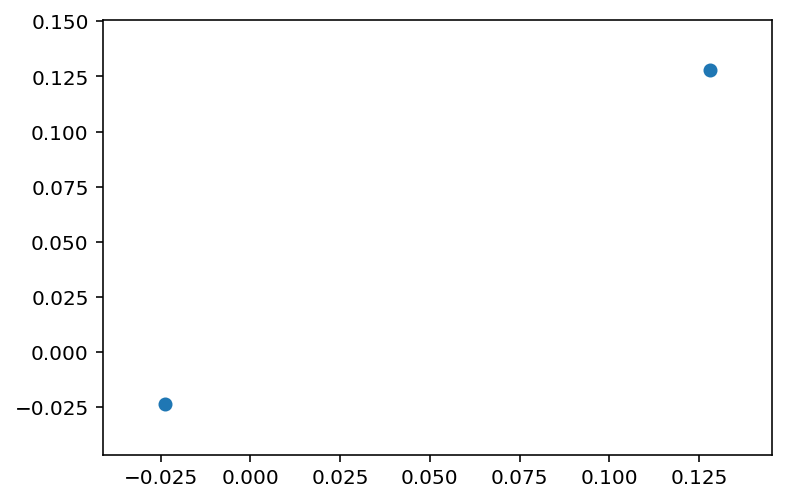

In [15]:
# Your code here

import matplotlib.pyplot as plt
samp=metropolis_hastings(Rosenbrock_lnP,[0,0],[0.1,0.1])
plt.scatter(samp[0],samp[1])

## Speeding things up

Broadly speaking, we can try to
1. tailor algorithms to specific classes of PDF
2. look for ways to make the general samplers more intelligent

We can also use different samplers for different subsets of parameters - the only rule is that every parameter must get updated somehow.

## Gibbs Sampling
is a specialization of Metropolis-Hastings:
* Instead of making a general proposal in all dimensions, we cycle through the parameters proposing changes to **one at a time**
* A proposal for $\theta_i$ is into the **fully conditional posterior** $p(\theta_i|\theta_{-i},x)$, where $-i$ means all subscripts other than $i$.

Gibbs sampling:
```
while we want more samples
    propose theta1 | theta2, theta3, ..., data
    accept/reject theta1
    propose theta2 | theta1, theta3, ..., data
    accept/reject theta2
    ...
```

### Example: normal PDF

25 Metropolis iterations (left) vs. 25 Gibbs transitions (right)

Color goes blue$\rightarrow$red with time (step number)

<table>
    <tr>
        <td>
            <img src="mc2_metro.png" width=100%>
        </td>
        <td></td>
        <td>
            <img src="mc2_gibbs.png" width=100%>
        </td>
    </tr>
</table>

In general, this is not obviously an improvement to proposing changes to all $\theta$ simultaneously.

Why is a random drunk walking in one specific direction at a time better than just taking a random step???

Something interesting happens if the fully conditional likelihood and prior are **conjugate** 

For some likelihood functions, if you choose a certain prior, *the posterior ends up being in the same distribution as the prior.* Such a prior then is called a **Conjugate Prior.**

i.e. 

# $$ P(\theta) \mathrm{\; such\; that\; } P(\theta|D) = P(\theta) $$


i.e. we know the conditional posterior exactly!

If we use independent samples of the conditional posterior as proposals, then the Metropolis-Hastings acceptance ratio becomes

## $$\frac{p(x')g(x|x')}{p(x)g(x'|x)} = \frac{p(x')p(x)}{p(x)p(x')} = 1$$

**and every proposal is automatically accepted!**

Conjugate Gibbs Sampling:
```
while we want more samples
    draw th1 from p(th1|th2,th3,...,data)
    draw th2 from p(th2|th1,th3,...,data)
    ...
```

* Beta posterior

    * Beta prior * Bernoulli likelihood → Beta posterior
    * Beta prior * Binomial likelihood → Beta posterior
    * Beta prior * Negative Binomial likelihood → Beta posterior
    * Beta prior * Geometric likelihood → Beta posterior

* Gamma posterior
   * Gamma prior * Poisson likelihood → Gamma posterior
   * Gamma prior * Exponential likelihood → Gamma posterior

* Normal posterior
    * Normal prior * Normal likelihood (mean) → Normal posterior

Gibbs Sampling Pros:
* No cycles "wasted" on rejected proposals
* No pesky tuning of the proposal scale

Gibbs Sampling Cons:    
* Only works for conjugate or partially conjugate models (hence must choose conjugate priors)
* Occasionally still slower than proposing multi-parameter Metropolis updates (e.g. when degeneracies are strong)

Some multiple modes:
<table>
    <tr>
        <td>
            Some spectral model<br>
            <img src="mc2_multimode_eg2.png" width=100%>
        </td>
        <td></td>
        <td>
            The eggbox function<br>
            <img src="mc2_eggbox.png" width=100%>
        </td>
    </tr>
</table>

In these cases, when we were talking about optimizers (as opposed to samplers) that used gradient descent, we found that local optimizers got stuck

<table>
    <tr>
        <td>
            Some spectral model<br>
            <img src="global_vs_local.png" width=100%>
        </td>
    </tr>
</table>

We talked about **simulated annealing** and **basin hopping** as examples of *global optimizers* that can get out of these local minima.

With MH, you'd have to make a large step size, but that has a major downside - your acceptance ratio goes down and your autocorrelation time goes up.

So, it's reasonable to ask if there's an analog for MCMC.

## Tempering
Consider the function $[p(x)]^{1/T}$, where $p(x)$ is the target PDF.
* We say a chain sampling this function has temperature $T$. For $T>1$, $p^{1/T}$ is smoothed out compared with $p$.
    * This is the same sort of thing that we saw with **simulated annealing** - start with sampling at a high temperature and then gradually lower the temperature with some schedule
* This allows chains to move among multiple peaks more easily.
* Of course, we're only actually interested in $T=1$...

### Parallel tempering

With parallel tempering, we run one chain with $T=1$ and several more chains with $T>1$. A modified Metropolis-Hastings update occasionally allows the chains to exchange positions, giving the $T=1$ chain a mechanism for sampling regions of parameter space it might otherwise have low probability of proposing. Samples from the $T=1$ chain can be used for inference.

## In Class Exercise: think

Recall the ugly PDF features we were motivated by, namely strong/nonlinear degeneracies and multiple modes.
For each of the methods above, do you expect an improvement compared with standard Metropolis in these situations. 

Why and for which methods?

<table>
    <tr>
        <td>
            <img src="mc2_rosenbrock.png" width=80%>
        </td>
        <td></td>
        <td>
            <img src="mc2_eggbox.png" width=80%>
        </td>
    </tr>
</table>

## Coping with multiple modes

Multiple, well separated posterior modes are a serious challenge for many samplers.
* In general, the only way to discover that they exist is by exploring the parameter space with many widely dispersed chains.
* To do inference, our chains need to be able to efficiently transition between modes - so far the most reliable general method we've seen for this is parallel tempering. 

## Implementations of other samplers that are commonly used in research:

1. Gibbs Sampling ([pymc3](https://docs.pymc.io/))
2. Parallel Tempering (now in [ptemcee](https://pypi.org/project/ptemcee/))
3. Hamiltonian Monte Carlo/No U-turn Sampling (also [pymc3](https://docs.pymc.io/))

And this is also a sampler, but is not actually a Markov Chain method (Monte Carlo is logically separate from Markov Chain Monte Carlo)
4. Nested Sampling ([dynesty](https://dynesty.readthedocs.io/en/latest/index.html) or [Multinest](https://johannesbuchner.github.io/PyMultiNest/))


We can't cover all of these, but you should have a good idea on how to start with any of them by now, and which one to pick for a particular problem.